# LSTM RNN MODEL DEMO WITH AAPL

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from sklearn import preprocessing
from datetime import datetime, timedelta

import tensorflow as tf 
import time
from collections import Counter
import os
os.chdir('..')

In [2]:
# Set up the GPU to avoid the runtime error: Could not create cuDNN handle...
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
##### HELPERS #####
def prettify_ax(ax):
    """Make an axis pretty"""
    # -for spine in ax.spines.itervalues():
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    """ingle prettified axis"""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    
    return fig, ax

def earliest_date_after(query_date, date_list):
    """Find the earliest date after a query date from ordered list of dates"""
    for i in range(len(date_list)):
        if query_date < date_list[i].date():
            return date_list[i].date()
    print('\nQUERY DATE ERROR WITH:', query_date, '\n')
    
    raise Exception('No values after query date')

def latest_date_before(query_date, date_list):
    """Find the latest date before a query date from ordered list of dates"""
    for i in range(len(date_list)):
        if query_date < date_list[i].date():
            if i==0:
                print('\nQUERY DATE ERROR WITH:', query_date, '\n')
                raise Exception('No values before query date in list')
                
            return date_list[i-1].date()
        
def inv_price_transform(normalized_data, scaler):
    """Inverse from normalized price to raw price"""
    m = scaler.mean_[0]
    s = scaler.scale_[0]
    
    return s * np.array(normalized_data) + m

# Load Data

In [4]:
def prep_data(ticker,
              stock_file = 'data/stock/prices-split-adjusted.csv', \
              news_directory = 'data/news/', \
              econ_file = 'data/market/economic_indicators.csv', \
              reddit_file = 'data/market/reddit_sentiments.csv'):
    """Merge stock closing price data, sec filing data, and newspaper sentiment into one dataframe"""
    
    # Load the data
    stock_df = pd.read_csv(stock_file, index_col=0)
    stock_df = stock_df[stock_df.symbol==ticker].close
    stock_df.index = pd.to_datetime(stock_df.index)
    news_df = pd.read_csv(news_directory+ticker+'.csv', index_col=0)
    news_df.index = pd.to_datetime(news_df.index)
    econ_df = pd.read_csv(econ_file, index_col=0)
    econ_df.index = pd.to_datetime(econ_df.index)
    reddit_df = pd.read_csv(reddit_file, index_col=0)
    reddit_df.index = pd.to_datetime(reddit_df.index)
    return_df = pd.DataFrame(columns=[stock_df.name]+['stock_'+a for a in list(news_df.columns)]+\
                             list(econ_df.columns)+['market_'+a for a in list(reddit_df.columns)])
    
    # Clip the price data that doesn't have news coverage or reddit coverage
    d0, d1 = news_df.index[0].date(), news_df.index[1].date()
    startdate = d0-(d1-d0)
    stock_df = stock_df.loc[startdate:]
    
    # iterate through rows, aggregating all data and appending to return_df
    for row_num in range(stock_df.shape[0]):
        new_row = []
        stock_date = stock_df.index[row_num].date()
        new_row += [stock_df.iloc[row_num]]
        new_row += list(news_df.loc[earliest_date_after(stock_date, news_df.index),:])
        new_row += list(econ_df.loc[latest_date_before(stock_date, econ_df.index),:])
        new_row += list(reddit_df.loc[earliest_date_after(stock_date, reddit_df.index),:])
        
        return_df.loc[stock_date] = new_row
        if row_num % 100 == 0:
            print("%i/%i rows done." % (row_num, stock_df.shape[0]),)
            
    print("\n%s dataframe prepped. %i timepoints, each with %i features." % \
          (ticker, return_df.shape[0], return_df.shape[1]))
    
    return return_df

# Practice with AAPL stock data
aapl_df = prep_data('AAPL')

0/1395 rows done.
100/1395 rows done.
200/1395 rows done.
300/1395 rows done.
400/1395 rows done.
500/1395 rows done.
600/1395 rows done.
700/1395 rows done.
800/1395 rows done.
900/1395 rows done.
1000/1395 rows done.
1100/1395 rows done.
1200/1395 rows done.
1300/1395 rows done.

AAPL dataframe prepped. 1395 timepoints, each with 14 features.


In [5]:
# Display head of X dataframe
aapl_df.head()

,close,stock_polarity,stock_subjectivity,stock_pos,stock_neg,stock_neu,CCI,BCI,CLI,market_neg,market_neu,market_pos,market_polarity,market_subjectivity
2011-06-17,45.751427,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368
2011-06-20,45.045715,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368
2011-06-21,46.471428,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368
2011-06-22,46.087143,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368
2011-06-23,47.318573,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368


In [6]:
def load_stock(df, lookback=25):
    """Scale data and split into training/test sets"""
    data = df.values
    n_train = list(df.index).index(df.index[-1]+timedelta(-365))
    scaler = preprocessing.StandardScaler() # Normalize mean-zero, unit-variance
    scaler.fit(data[:n_train,:])
    data = scaler.transform(data)
    dataX, dataY = [], []
    
    for timepoint in range(data.shape[0]-lookback):
        dataX.append(data[timepoint:timepoint+lookback,:])
        dataY.append(data[timepoint+lookback,0])
    X_train, X_test = dataX[:n_train], dataX[n_train:]
    y_train, y_test = dataY[:n_train], dataY[n_train:]
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Load practice stock, AAPL
lookback = 25
X_train, y_train, X_test, y_test, scaler = load_stock(df=aapl_df, lookback=lookback)

1142 training examples, 228 test examples


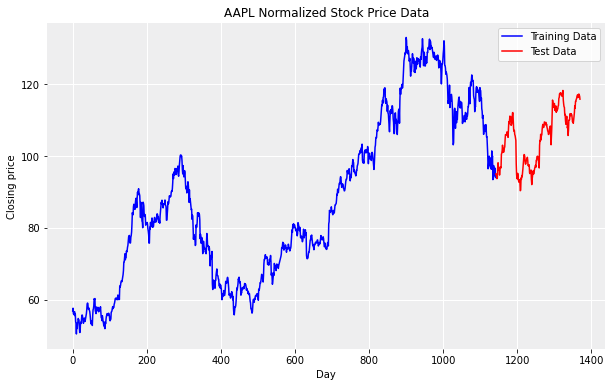

In [7]:
# Denormalize training and test the price data and plot it 
print("%i training examples, %i test examples" % (len(y_train), len(y_test)))

f, a = simple_ax(figsize=(10,6))
a.plot(range(len(y_train)), inv_price_transform(y_train, scaler), c='b', label='Training Data')
a.plot(range(len(y_train),len(y_test)+len(y_train)), inv_price_transform(y_test, scaler), c='r', label='Test Data')
a.set_title('AAPL Normalized Stock Price Data')
a.set_xlabel('Day')
a.set_ylabel('Closing price')
plt.legend()
plt.show()

# Train LSTM RNN

In [8]:
# build model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
# -model.add(Dense(32, kernel_initializer="uniform", activation='relu'))        
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 128)           73216     
_________________________________________________________________
dropout (Dropout)            (None, 25, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 204,929
Trainable params: 204,929
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Fit the model
t0 = time.time()
history = model.fit(X_train,
                    y_train,
                    batch_size=512,
                    epochs=200,
                    validation_split=0.05,
                    verbose=0)
print("TRAINING DONE. %i seconds to train." % int(time.time()-t0))

TRAINING DONE. 16 seconds to train.


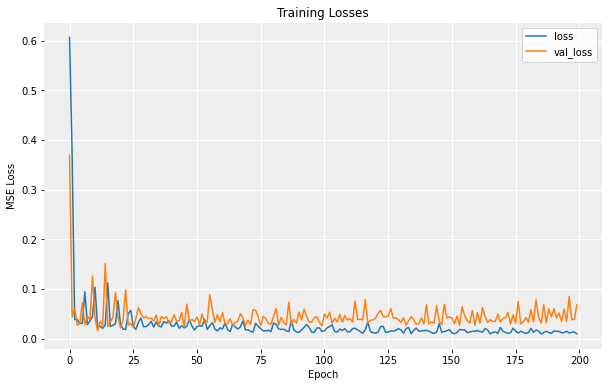

In [10]:
# Plot both the loss and the validation loss
f, a = simple_ax(figsize=(10,6))
a.plot(history.history['loss'], label='loss')
a.plot(history.history['val_loss'], label='val_loss')
a.set_title('Training Losses')
a.set_xlabel('Epoch')
a.set_ylabel('MSE Loss')
plt.legend()
plt.show()

In [11]:
##### SAVE MODEL #####
"""
model0 : 12/3/2017 (incomplete data)
model1 : 12/4/2017 (complete dataset)
"""
model.save('/home/mic/Documents/Stock-Prediction/models/model1.h5')

# Predict Future Prices

In [12]:
#### LOAD MODEL #####
# -model = load_model('/home/mic/Documents/Stock-Prediction/models/model0.h5')
model = load_model('/home/mic/Documents/Stock-Prediction/models/model2.h5')

RMSE:  0.422318767992908


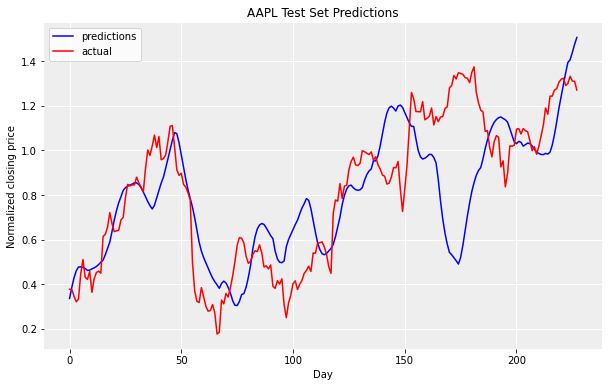

In [13]:
# Predict the test set
predictions = model.predict(X_test)
print("RMSE: ", np.sqrt(np.mean((predictions-y_test)**2)))

f, a = simple_ax(figsize=(10,6))
a.plot(predictions, c='b', label='predictions')
a.plot(y_test, c='r', label='actual')
a.set_ylabel('Normalized closing price')
a.set_xlabel('Day')
a.set_title('AAPL Test Set Predictions')
plt.legend()
plt.show()

In [14]:
def predict_days(startday, days_topredict, data, model):
    """Starting from startday predict days_topredict stock prices"""
    curr_data = data[startday,:,:]
    predictions = []
    for day in range(days_topredict):
        prediction = model.predict(curr_data.reshape(1,curr_data.shape[0],curr_data.shape[1]))[0][0]
        predictions.append(prediction)
        new_row = curr_data[-1,:]
        new_row[0] = prediction
        curr_data = np.vstack((curr_data[1:,:], new_row))
        
    return predictions

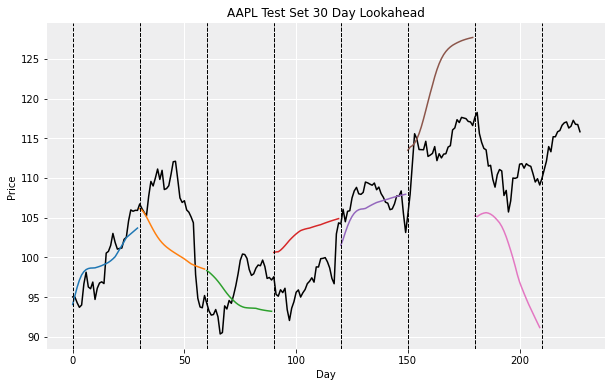

In [15]:
# Predict multiple days in future and plot price projection path
days = 30
f, a = simple_ax(figsize=(10,6))

a.plot(inv_price_transform(y_test,scaler), c='k')

for segment in range(int(len(y_test)/days)):
    predictions = predict_days(segment*days, days, X_test, model)
    a.plot(range(segment*days, segment*days+days), inv_price_transform(predictions, scaler))
    a.axvline(segment*days, c='k', linestyle='dashed', linewidth=1)
    a.axvline(segment*days+days, c='k', linestyle='dashed', linewidth=1)
    
a.set_xlabel('Day')
a.set_ylabel('Price')
a.set_title('AAPL Test Set 30 Day Lookahead')
plt.show()

In [16]:
def decide_buy_sell(startpoint, days_topredict, data, model, return_threshold):
    """
    predict future prices and return a market decision
    - returns True: "buy long"
    - returns False: "sell short"
    - returns None: "do nothing"
    """
    predictions = predict_days(startpoint, days_topredict, data, model)
    startprice, maxprice, minprice = predictions[0], max(predictions), min(predictions)
    buyreturn = (maxprice-startprice)/startprice
    sellreturn = (startprice-minprice)/startprice
    if buyreturn>=sellreturn and buyreturn>=return_threshold:
        return True
    elif sellreturn>buyreturn and sellreturn>=return_threshold:
        return False
    
    return None

def walk_buy_sell(data, model, return_threshold=.05, days_topredict=30):
    """Walk data making buy/sell decisions"""
    buy_dates, sell_dates = [], []
    
    for t in range(len(y_test)):
        decision = decide_buy_sell(t, days_topredict, data, model, return_threshold)
        if decision is True:
            buy_dates.append(t)
        elif decision is False:
            sell_dates.append(t)
        if t%20==0:
            print("%i/%i timepoints calculated." % (t+1,len(y_test)),)
    print("Data walk complete.")
    
    return buy_dates, sell_dates

buy_dates, sell_dates = walk_buy_sell(X_test, model, return_threshold=0.5, days_topredict=30)

1/228 timepoints calculated.
21/228 timepoints calculated.
41/228 timepoints calculated.
61/228 timepoints calculated.
81/228 timepoints calculated.
101/228 timepoints calculated.
121/228 timepoints calculated.
141/228 timepoints calculated.
161/228 timepoints calculated.
181/228 timepoints calculated.
201/228 timepoints calculated.
221/228 timepoints calculated.
Data walk complete.


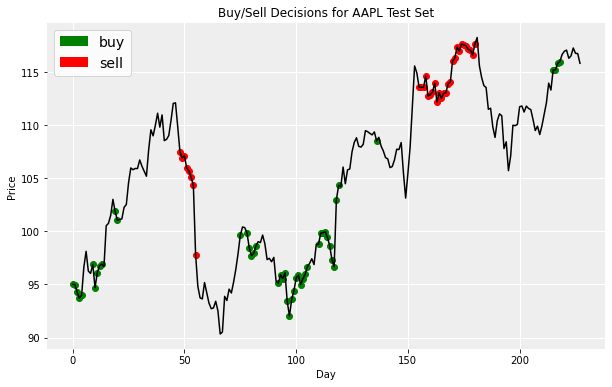

In [17]:
# Plot the buy/sell timepoint decisions
f, a = simple_ax(figsize=(10,6))
a.plot(inv_price_transform(y_test, scaler), c='k')
a.scatter(buy_dates, inv_price_transform(y_test[buy_dates],scaler), c='g')
a.scatter(sell_dates, inv_price_transform(y_test[sell_dates],scaler), c='r')
a.set_xlabel('Day')
a.set_ylabel('Price')
a.set_title('Buy/Sell Decisions for AAPL Test Set')
recs = [mpatches.Rectangle((0,0),1,1,fc='g'), mpatches.Rectangle((0,0),1,1,fc='r')]
a.legend(recs,['buy', 'sell'], loc=2, prop={'size':14})
plt.show()

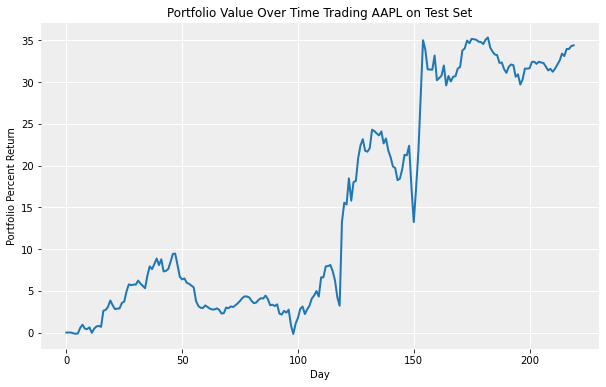

In [18]:
# Simulate portfolio value using buy/sell decisions
init_value = 10000
stocks_per_trade = 5
cash = init_value
portfolio = Counter()
returns = [0]

for date in range(max(buy_dates+sell_dates)+1):
    if date in buy_dates: #buy
        portfolio['AAPL'] += stocks_per_trade
        cash = cash - stocks_per_trade*inv_price_transform(y_test[date], scaler)
    elif date in sell_dates: #sell
        portfolio['AAPL'] -= stocks_per_trade
        cash = cash + stocks_per_trade*inv_price_transform(y_test[date], scaler)
    curr_value = cash + portfolio['AAPL']*inv_price_transform(y_test[date],scaler)
    curr_return = 100*(curr_value - init_value)/init_value
    returns.append(curr_return)
    
f, a = simple_ax(figsize=(10,6))
a.plot(returns, linewidth=2)
a.set_xlabel('Day')
a.set_ylabel('Portfolio Percent Return')
a.set_title('Portfolio Value Over Time Trading AAPL on Test Set')
plt.show()

In [19]:
from numba import cuda

cuda.select_device(0)
cuda.close()